
New Years to-do
1. Overall
-Check which compounds have trivial names, kick out Rest (or anonymise)
-Replace with trivial names
-Residual Frac clusters
-Rename to RNAseq vs. Multiplexed RNAseq

3. Correlations
- Post production:Add Frac cluster and MoA on the side

4. Stripplot
- Post production: Do FRAC and cluster labels
- throw out pypy?

5. Embeddings
- Put in panels with Stripplot

8. Venn diagrams cut-offs
- Postprodution: Venns have to get smaller when theres less genes
- Put average gene lengths into description?

In [1]:
import pandas as pd
import numpy as np
import os

#df_norm = pd.read_csv("full_norm_matrix_and_meta.csv", index_col=0)
df_raw = pd.read_csv("full_raw_matrix_and_meta.csv", index_col = 0)

In [2]:
df = df_raw
scanpy_normalisation = True # Normalise count data (not necessary when taking df_norm)
outlier_removal = True # Use Isolation forest for outlier removal
limit_to_gene_subset = False # Limit the analysis to a subset of genes
cut_samples_fraction = 0.05 # Fraction of samples to cut based on at least x expressed genes
cut_genes_fraction = 0.05 # Fraction of genes to cut based on expression in at least x samples

In [ ]:
df_meta = pd.read_csv("transcriptomics_moa_target 1.csv", index_col = 0)
df_meta.loc[df_meta["Pathway / Target"] == "DMSO", "MoA"] = "DMSO"
df_meta.loc[df_meta["Pathway / Target"] == "DMSO", "Target"] = "DMSO"
#df_meta.columns = [ "Metadata_" + x for x in df_meta.columns]
moa_dict = dict(zip(df_meta["BCS-code"], df_meta["MoA"]))
moa_dict["DMSO"] = "DMSO"
target_dict = dict(zip(df_meta["BCS-code"], df_meta["Target"]))
target_dict["DMSO"] = "DMSO"

In [4]:
df["Metadata_MoA"] = np.nan
df["Metadata_target"] = np.nan
df["Metadata_MOA"] = df["Metadata_treatments"].map(moa_dict)
df["Metadata_target"] = df["Metadata_treatments"].map(target_dict)

In [5]:
print(df.shape)
df.rename(columns = {
    "Metadata_MOA" : "Metadata_Mode_of_Action",
    "Metadata_treatments": "Metadata_treatments",
}, inplace = True)
df.loc[df["Metadata_treatments"] == "DMSO", "Metadata_concentration"] = 1

df = df[~df["Metadata_Mode_of_Action"].isna()]
df = df[~df["Metadata_target"].isna()]


(1440, 12204)


In [6]:
df["Metadata_log_concentration"] = np.log10(df["Metadata_concentration"].astype(float).fillna(0))

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
gene_columns = [ col for col  in df.columns if "Metadata" not in col]
metadata_columns = [ col for col  in df.columns if "Metadata" in col]

In [8]:
if scanpy_normalisation==False:
    # Select the 250 columns with the highest variance
    top_250_columns = list(df[gene_columns].var().nlargest(250).index)
    df = df[top_250_columns + metadata_columns]
    gene_columns = top_250_columns

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Array of categories
unique_prefixes = df["Metadata_Mode_of_Action"].unique()

# Generate a base color for each unique prefix
base_colors = sns.color_palette("Set2", n_colors=len(unique_prefixes))  # Use a distinct palette
# Create a dictionary mapping categories to colors
category_color_map = {cat: color for cat, color in zip(unique_prefixes, base_colors)}

In [10]:
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

def outlier_pca(df):
    # Assuming df is your DataFrame and cellranger_feats is a list of feature names
    meta_columns = df.columns[df.columns.str.startswith("Metadata_")]
    gene_columns = df.columns[~df.columns.str.startswith("Metadata_")]

    pca = PCA(n_components=2)  # We want to reduce to 2 dimensions for plotting
    principal_components = pca.fit_transform(df[gene_columns])

    envelope = IsolationForest(contamination="auto", n_jobs=-1, random_state=42)  # Adjust contamination as needed
    envelope.fit(df[gene_columns])
    pca_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
    pca_df["Metadata_treatments"] = list(df["Metadata_treatments"])
    pca_df["Metadata_log_concentration"] = list(df["Metadata_log_concentration"])

    pca_df["Metadata_Mode_of_Action"] = list(df["Metadata_Mode_of_Action"])
    outlier_list = envelope.predict(df[gene_columns])  # True for outliers
    pca_df["Outlier"] = outlier_list
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=pca_df,
        x="PC1",
        y="PC2",
        hue="Metadata_Mode_of_Action",
        palette="Set2",
        size="Metadata_log_concentration",
        # sizes=(20, 200),
        alpha=0.7,
    )
    ax = plt.gca()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    # Highlight outliers
    outliers = pca_df[pca_df["Outlier"] == -1]
    plt.scatter(
        outliers["PC1"],
        outliers["PC2"],
        color="black",
        edgecolor="black",
        label="Outliers",
        s=20,
        marker="x",
        alpha=0.5,
    )
    plt.show()
    df = df[outlier_list != -1]
    return df

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/matplotlib/colors.py:1370: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/matplotlib/colors.py:1371: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/tmp/ipykernel_97820/4215816646.py:40: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplot

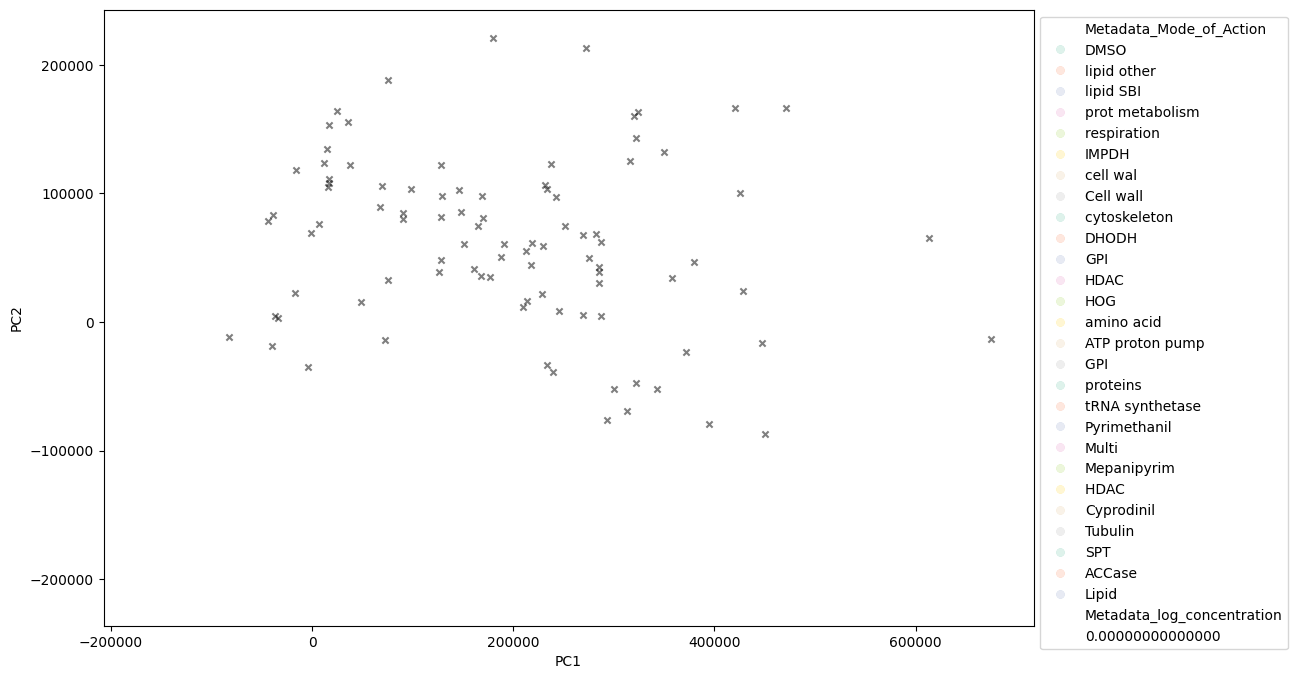

In [11]:
if outlier_removal:
    df = outlier_pca(df)

/tmp/ipykernel_97820/2017277572.py:7: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X=df[gene_columns].reset_index(drop=True).fillna(0),
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' f

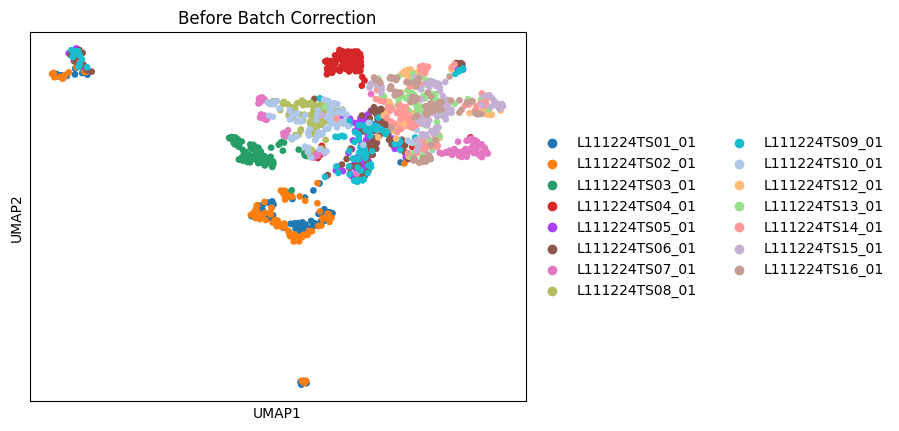

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


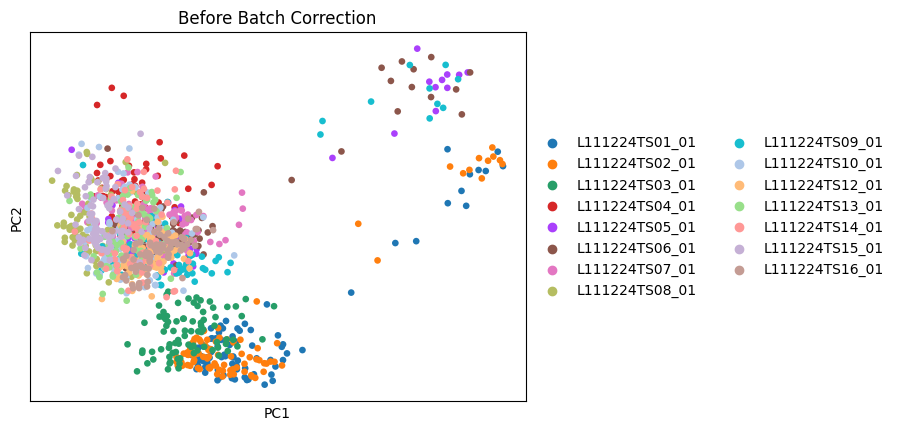

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_info = model.groupby(key).indices.values()
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_items = model.groupby(batch_key).groups.items()
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categ

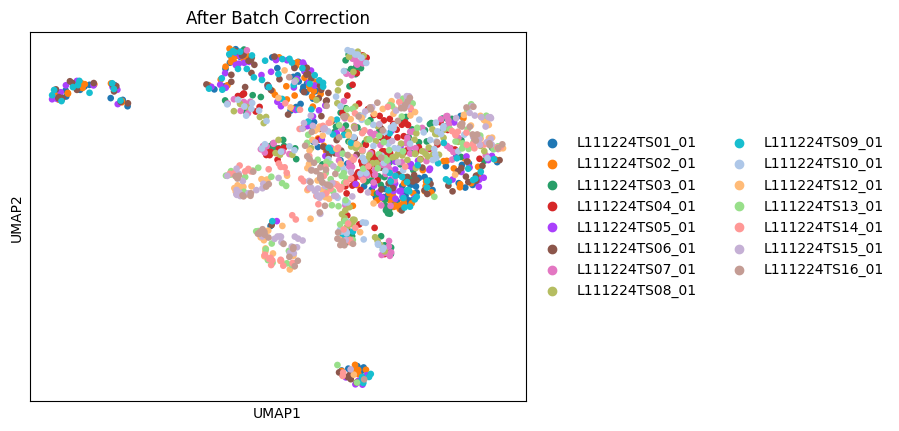

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


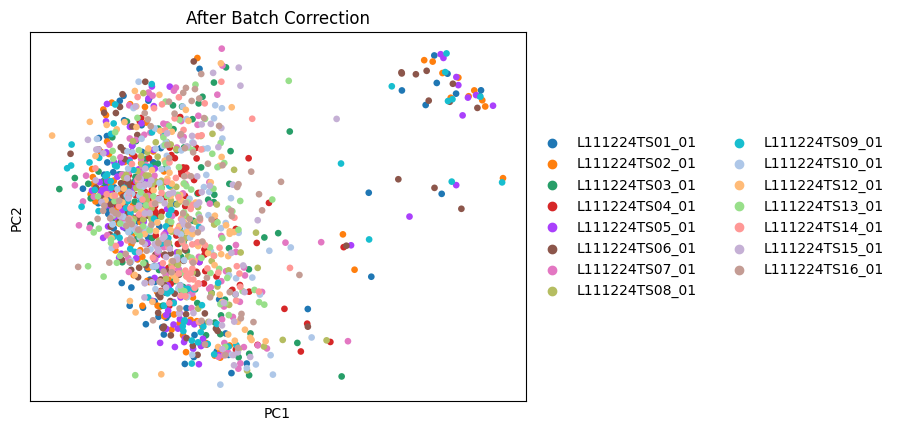

In [12]:
import scanpy as sc
import anndata
from scanpy.external import pp as external_pp


# Create AnnData object
adata = anndata.AnnData(X=df[gene_columns].reset_index(drop=True).fillna(0), 
                         obs=df[metadata_columns].reset_index(drop=True))

# Filter out low-frequency modes of action
mode_of_action_counts = adata.obs["Metadata_Mode_of_Action"].value_counts()
filtered_modes = mode_of_action_counts[mode_of_action_counts >= 10].index
adata = adata[adata.obs["Metadata_Mode_of_Action"].isin(filtered_modes)]

if scanpy_normalisation:
    # Step 1: Filter cells and genes with adjusted thresholds
    sc.pp.filter_cells(adata, min_counts=df.shape[1] * cut_samples_fraction)
    sc.pp.filter_genes(adata, min_counts=df.shape[0] * cut_genes_fraction)

    # Step 2: Calculate quality control metrics
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True)

    # Step 3: Normalize total counts
    sc.pp.normalize_total(adata, target_sum=10000, exclude_highly_expressed=True)

    # Step 4: Log-transform the data
    sc.pp.log1p(adata)

    # Step 5: Regress out the effects of total counts
    sc.pp.regress_out(adata, ["total_counts"])

    # Step 6: Identify highly variable genes if excluding highly expressed
    if limit_to_gene_subset:
        sc.pp.highly_variable_genes(adata)
        adata = adata[:, adata.var.highly_variable]

    # Step 7: Visualize before batch correction
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='Metadata_plate', title='Before Batch Correction')
    sc.pl.pca(adata, color='Metadata_plate', title='Before Batch Correction')

    # Step 8: Batch correction using ComBat
    sc.pp.combat(adata, key='Metadata_plate')

    # Step 9: After correction visualization
    sc.tl.pca(adata)  # Recompute PCA after correction
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='Metadata_plate', title='After Batch Correction')
    sc.pl.pca(adata, color='Metadata_plate', title='After Batch Correction')

else:
    # If not normalizing, just visualize before batch correction
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='Metadata_plate', title='Before Batch Correction')
    sc.pl.pca(adata, color='Metadata_plate', title='Before Batch Correction')

    # Batch correction
    sc.pp.combat(adata, key='Metadata_plate')

    # After correction visualization
    sc.tl.pca(adata)  # Recompute PCA after correction
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='Metadata_plate', title='After Batch Correction')
    sc.pl.pca(adata, color='Metadata_plate', title='After Batch Correction')

# Optional: Scale the data to unit variance
# sc.pp.scale(adata)

# Perform Principal Component Analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


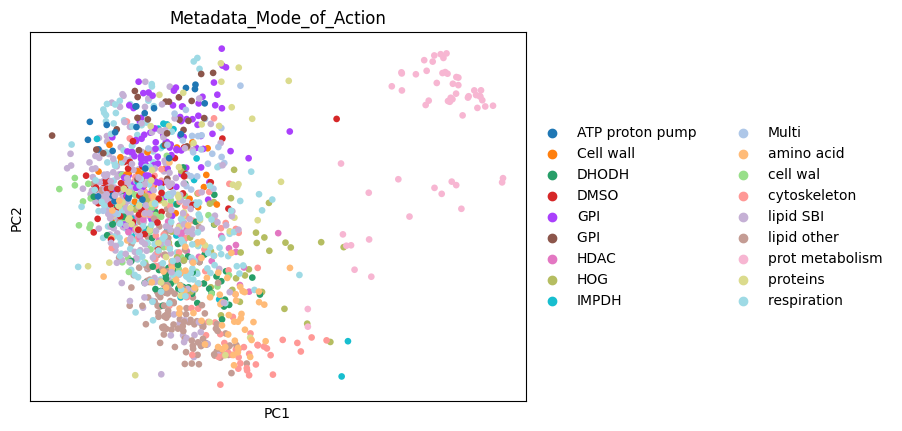

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


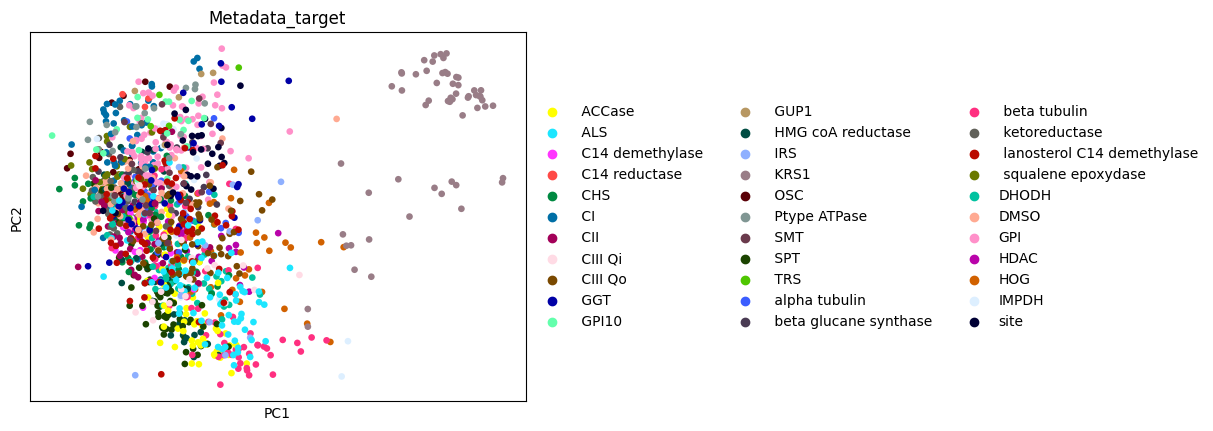

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


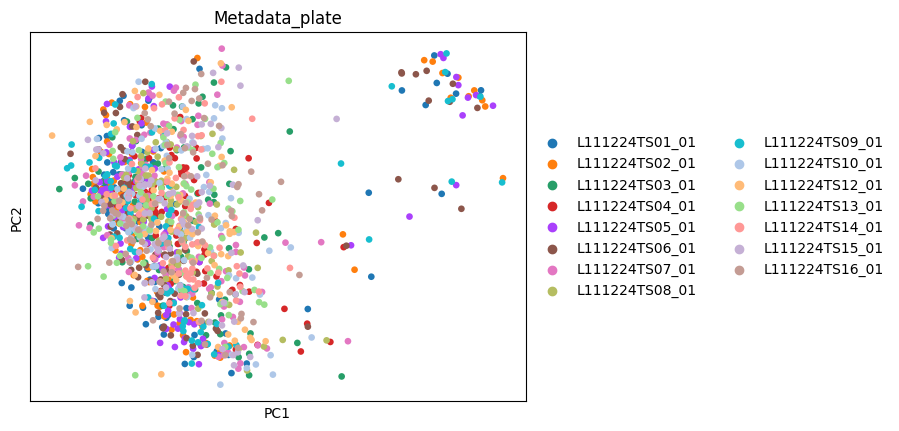

In [13]:
import matplotlib.pyplot as plt
# Additional plots for validation

sc.pl.pca(adata, color="Metadata_Mode_of_Action")
plt.show()
sc.pl.pca(adata, color="Metadata_target")
plt.show()
sc.pl.pca(adata, color="Metadata_plate")
plt.show()


In [1]:
# Compute the neighborhood graph
sc.pp.neighbors(adata,
    n_neighbors = 10,
    #n_pcs = 10
)

# Run Metadata_leidening
sc.tl.leiden(
    adata,
    #resolution=0.99
)

# Run PAGA
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, plot=False)

# Perform UMAP
sc.tl.umap(
    adata,
    min_dist=0.99, 
    init_pos='paga'
)

# Check the separation of clusters in UMAP
sc.pl.umap(adata, color='Metadata_Mode_of_Action')
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color='Metadata_target')


NameError: name 'sc' is not defined

In [15]:
adata_backup = adata.copy()

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

def plot_clusters(adata, col="Metadata_target"):
    """
    Plot clustered heatmap of the specified column in the AnnData object.
    
    Parameters:
    adata (anndata.AnnData): The AnnData object containing the data.
    col (str): The column name in adata.obs to be used for clustering.
    """
    # Create a dendrogram for the specified column
    sc.tl.dendrogram(adata, col, optimal_ordering=True, key_added="dendro")
    
    # Extract cluster membership and specified column
    cluster_membership = adata.obs[["leiden", col]].drop_duplicates()

    # Convert specified column to a one-hot encoded format
    cluster_membership.set_index(col, inplace=True)
    cluster_membership = pd.get_dummies(cluster_membership)

    # Create a clustered heatmap based on the cluster membership
    g = sns.clustermap(
        cluster_membership * -1,  # Invert the values for visualization
        cmap="mako",
        metric="hamming",
        linecolor='white',  # Line color for the heatmap
        yticklabels=True  # Show all y-tick labels
    )
    
    # Rotate x-tick labels by 45 degrees for better readability
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)  
    
    # Ensure that all y-tick labels are displayed
    for label in g.ax_heatmap.get_yticklabels():
        label.set_visible(True)

    plt.show()  # Display the plot

def median_expression_leiden(adata, col2group):
    """
    Calculate median gene expression grouped by a specified column and perform PCA and clustering.
    
    Parameters:
    adata (anndata.AnnData): The AnnData object containing the data.
    col2group (str): The column name in adata.obs to group by.
    
    Returns:
    new_adata (anndata.AnnData): A new AnnData object with median expression data.
    """
    # Create a DataFrame from the AnnData object
    expression_df = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)

    # Add the grouping column to the DataFrame
    expression_df[col2group] = adata.obs[col2group]

    # Calculate the median expression for each gene grouped by the specified column
    median_expression = expression_df.groupby(col2group).median()
    
    # Resetting index to include the grouping column
    median_expression[col2group] = median_expression.index
    median_expression.reset_index(drop=True, inplace=True)

    print(median_expression.shape)  # Print the shape of the median expression DataFrame

    # Create dictionaries for mapping metadata
    target_dict = dict(zip(adata.obs[col2group], adata.obs["Metadata_target"]))
    moa_dict = dict(zip(adata.obs[col2group], adata.obs["Metadata_Mode_of_Action"]))

    # Map the metadata to the median expression DataFrame
    median_expression["Metadata_Mode_of_Action"] = median_expression[col2group].map(moa_dict)
    median_expression["Metadata_target"] = median_expression[col2group].map(target_dict)
    
    # Create a new AnnData object with median expression data
    gene_columns = median_expression.columns[~median_expression.columns.str.startswith("Metadata_")]
    meta_columns = median_expression.columns[median_expression.columns.str.startswith("Metadata_")]

    new_adata = anndata.AnnData(
        X=median_expression[gene_columns].reset_index(drop=True),
        obs=median_expression[meta_columns].reset_index(drop=True)
    )

    # Perform PCA on the new AnnData object
    sc.tl.pca(new_adata, svd_solver='arpack')

    # Plot PCA results colored by metadata
    sc.pl.pca(new_adata, color="Metadata_Mode_of_Action")
    sc.pl.pca(new_adata, color="Metadata_target")

    # Compute the neighborhood graph for clustering
    sc.pp.neighbors(new_adata, n_neighbors=25)

    # Run Leiden clustering
    sc.tl.leiden(new_adata, resolution=0.99)

    # Run PAGA for trajectory analysis
    sc.tl.paga(new_adata, groups='leiden')
    sc.pl.paga(new_adata, plot=False)

    # Perform UMAP for visualization
    sc.tl.umap(new_adata, min_dist=0.99, init_pos='paga')

    # Check the separation of clusters in UMAP
    sc.pl.umap(new_adata, color='Metadata_Mode_of_Action')
    sc.pl.umap(new_adata, color='Metadata_target')
    sc.pl.umap(new_adata, color='leiden')
    
    # Plot clusters for both metadata columns
    plot_clusters(new_adata.copy(), "Metadata_Mode_of_Action")
    plot_clusters(new_adata.copy(), "Metadata_target")
    
    return new_adata  # Return the new AnnData object

In [17]:
adata.obs["leiden"] = [ f"Leiden cluster {x}" for x in adata.obs["leiden"]]

In [18]:
leiden_dict = dict(zip(adata.obs["Metadata_treatments"], adata.obs["leiden"]))

In [19]:
import pickle
pickle.dump(leiden_dict, open("leiden_dict_lyon.pkl", "wb"))

In [20]:
adata.write('lyon_transcriptomics_scanpy_normalised.h5')  # Save as HDF5 file

/tmp/ipykernel_97820/350811859.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_expression = expression_df.groupby(col2group).median()


(266, 11375)


/tmp/ipykernel_97820/350811859.py:86: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  new_adata = anndata.AnnData(
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/

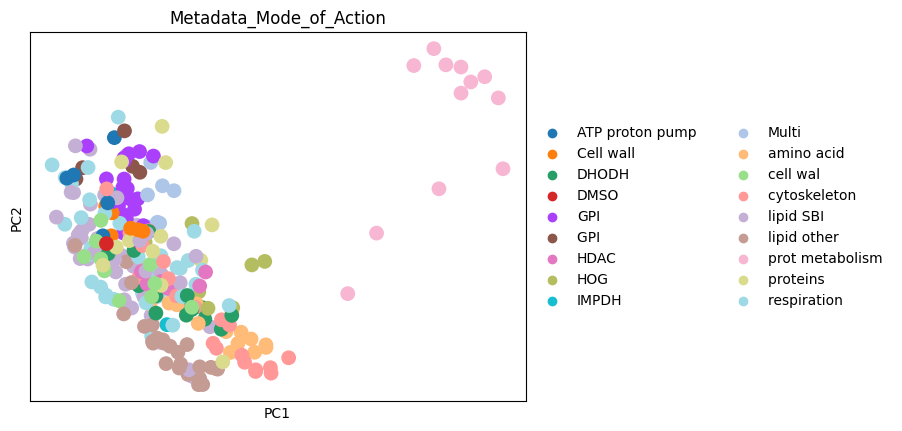

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


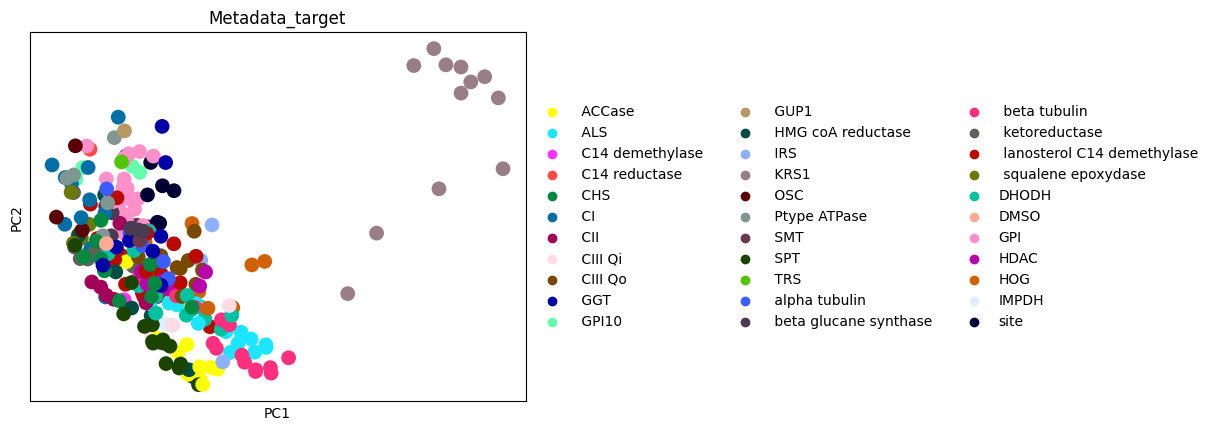

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


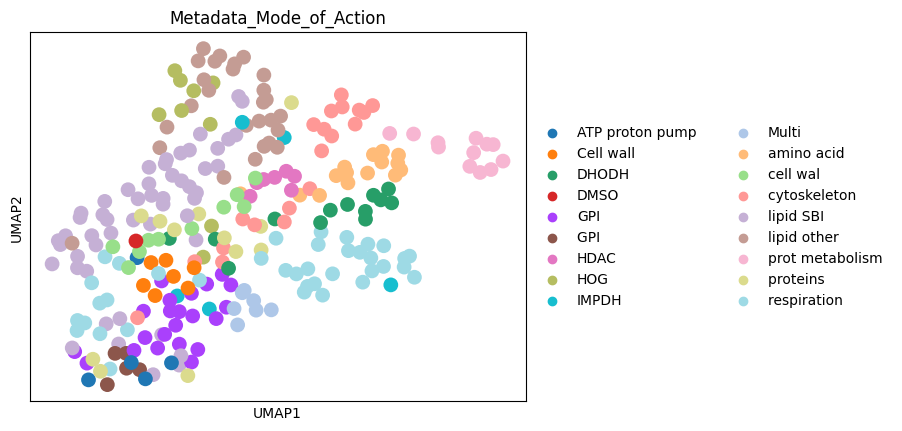

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


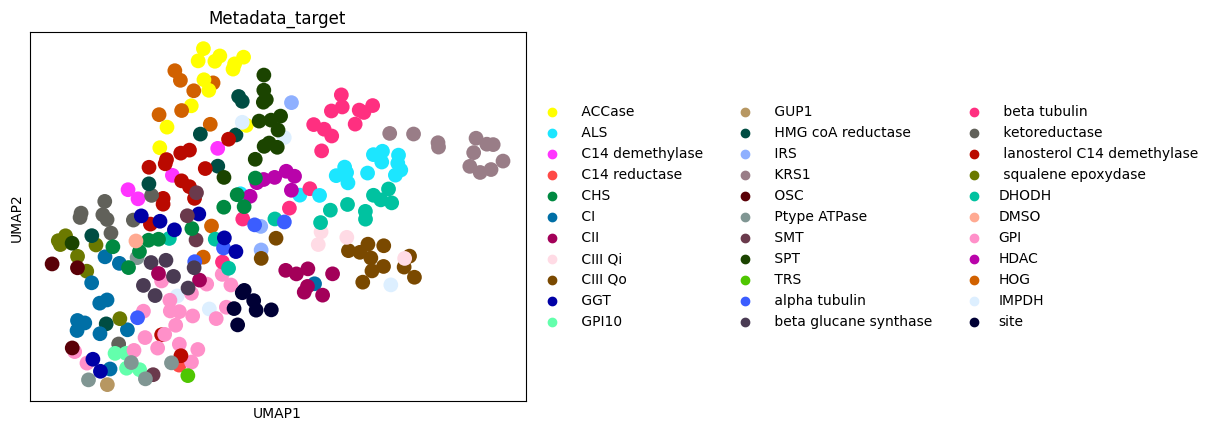

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


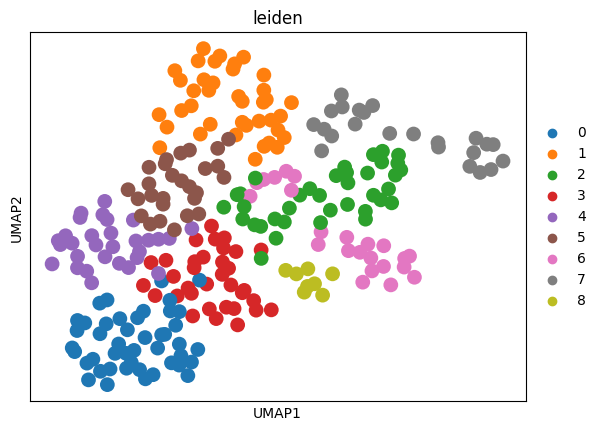

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


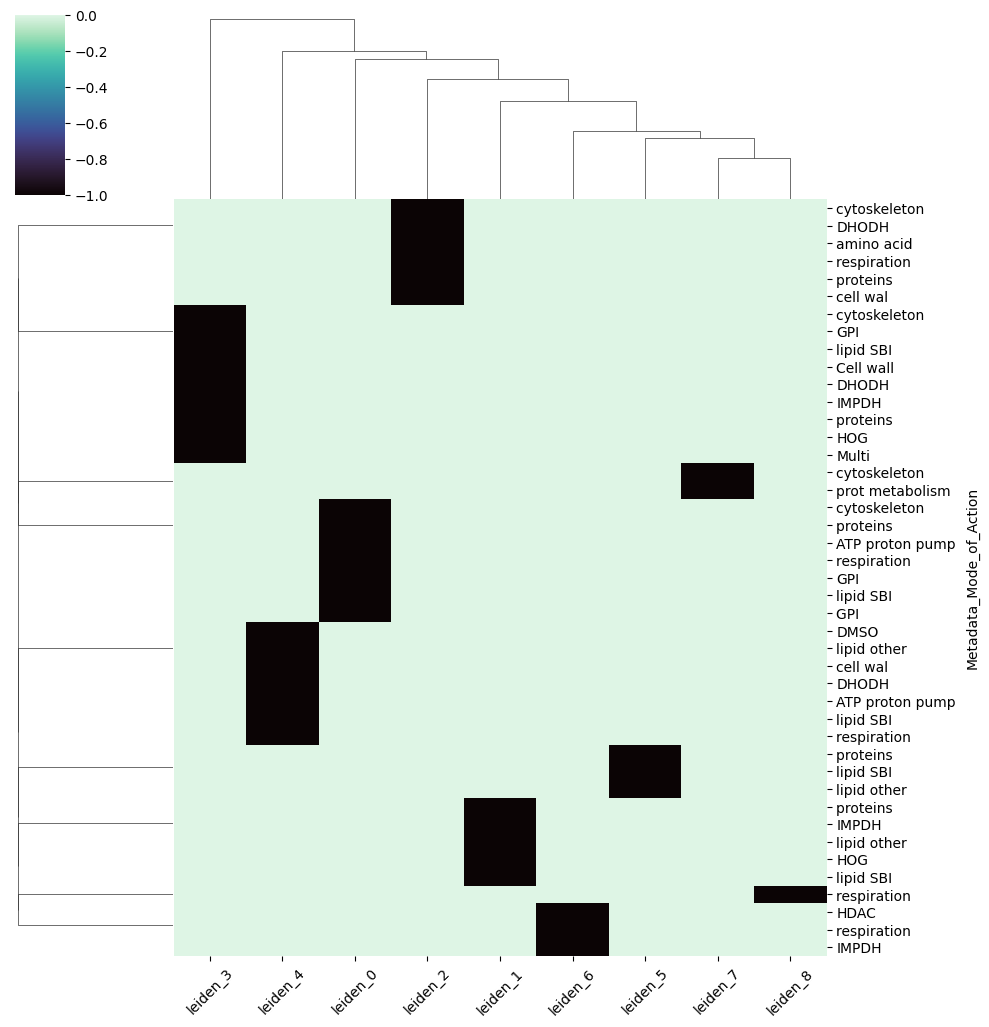

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


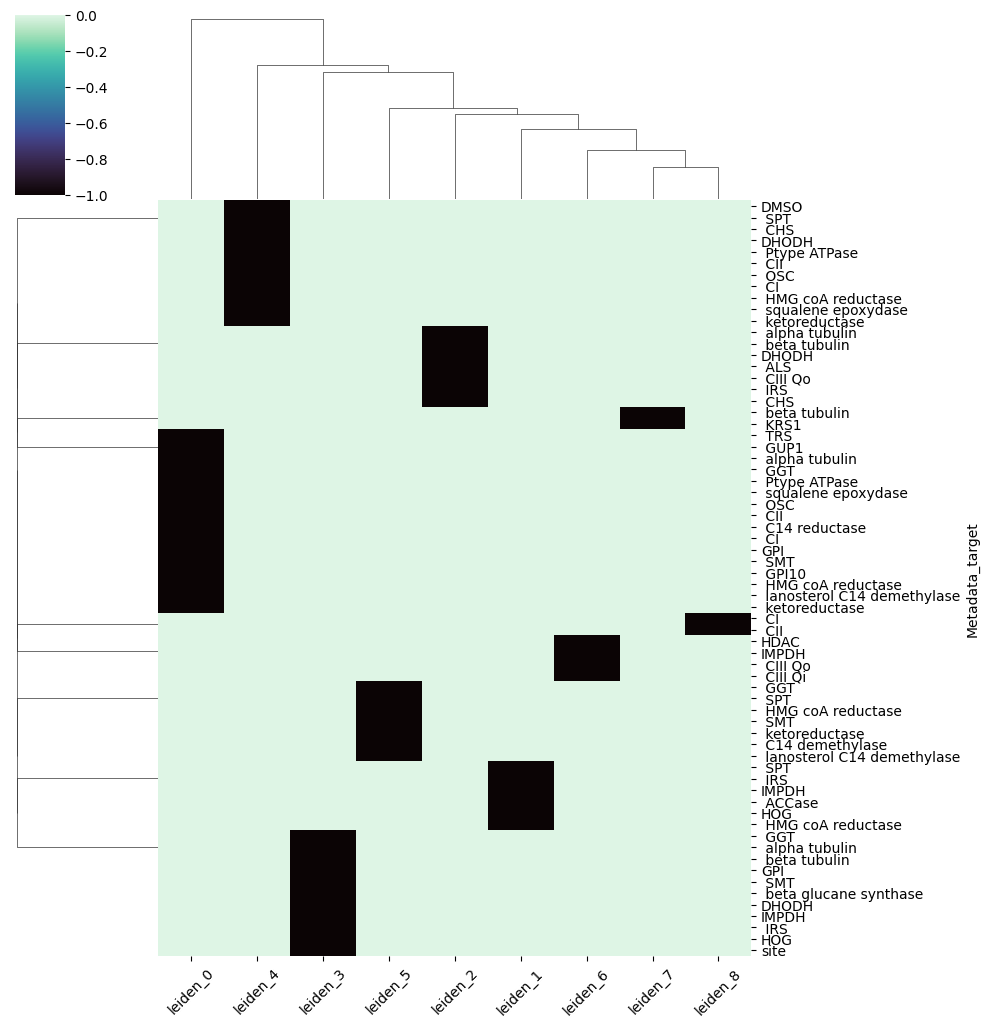

In [21]:
groupby_adata = median_expression_leiden(adata, "Metadata_treatments")
#median_expression_leiden(adata_backup.copy(), "Metadata_target")
#median_expression_leiden(adata_backup.copy(), "Metadata_Mode_of_Action")

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


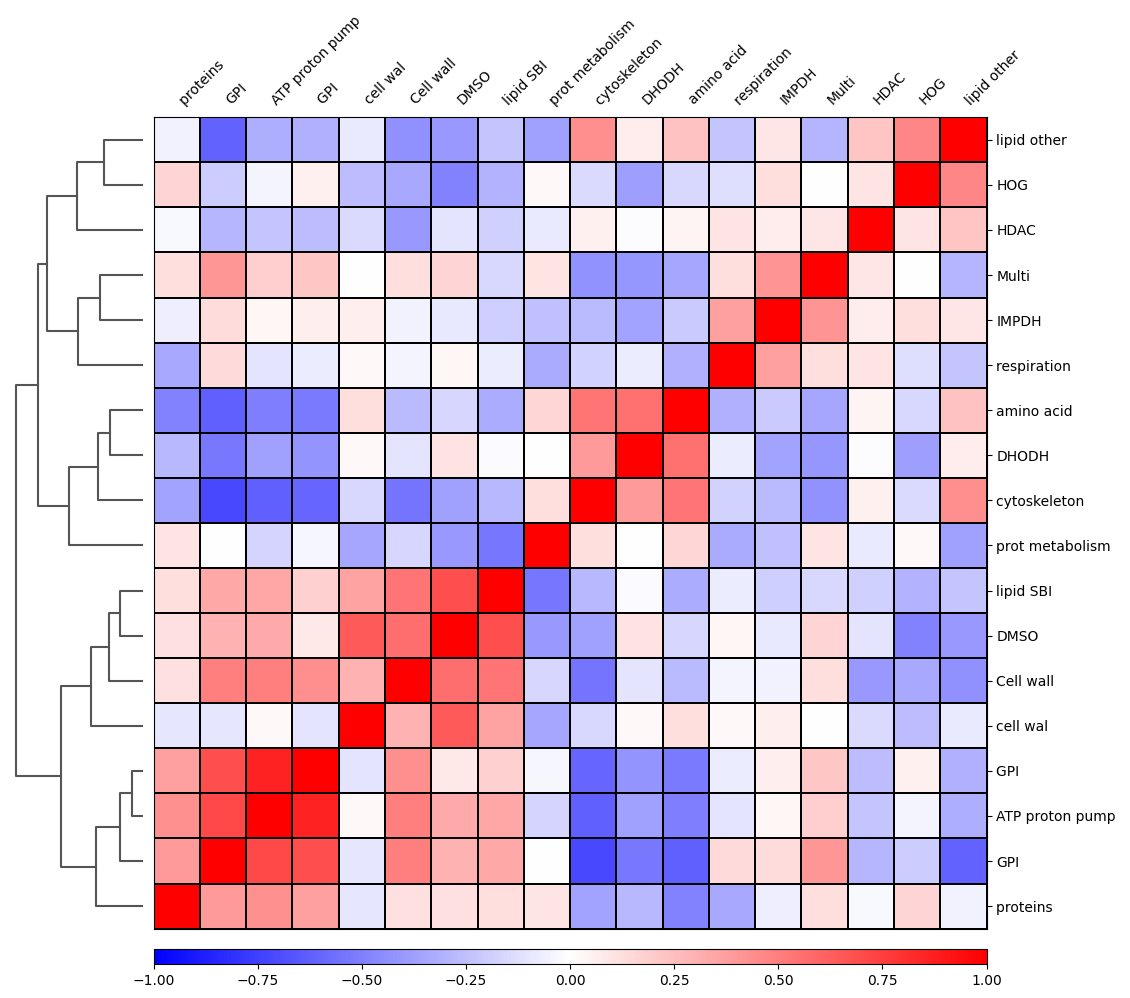

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


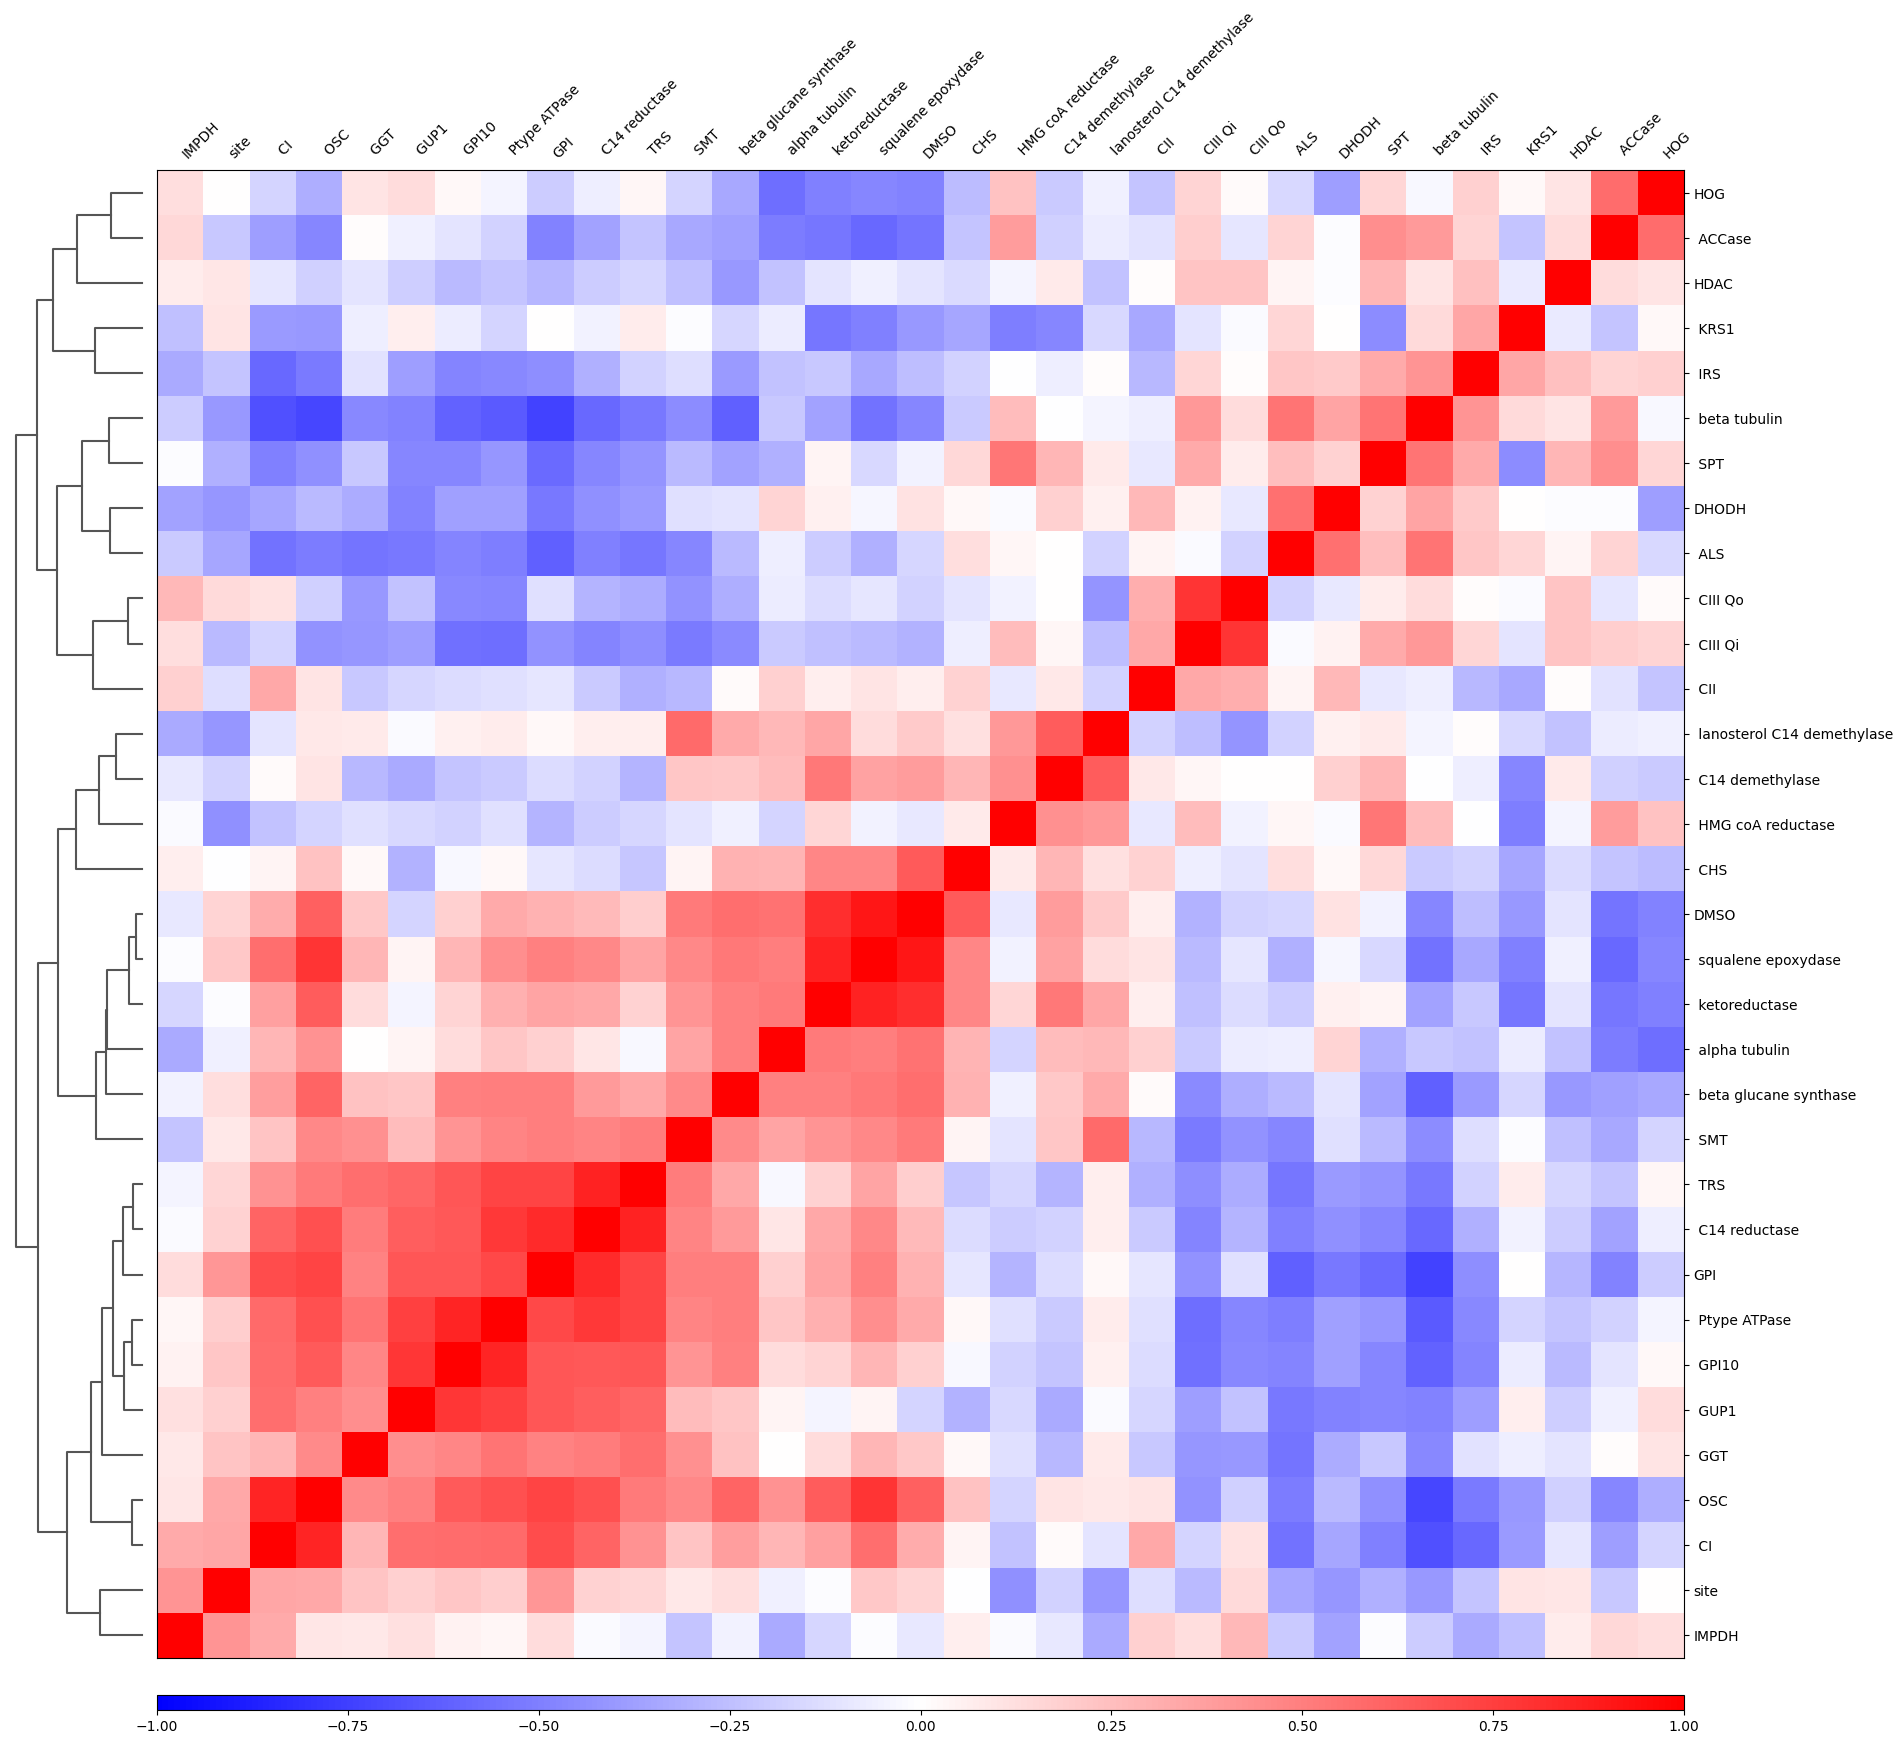

In [22]:
# ax = sc.pl.correlation_matrix(adata, "Metadata_treatments", show=True)  # Prevents the plot from displaying
ax = sc.pl.correlation_matrix(groupby_adata, "Metadata_Mode_of_Action", show=True)  # Prevents the plot from displaying
ax = sc.pl.correlation_matrix(groupby_adata, "Metadata_target", show=True)  # Prevents the plot from displaying

#ax = sc.pl.correlation_matrix(adata, "leiden", show=True)  # Prevents the plot from displaying

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


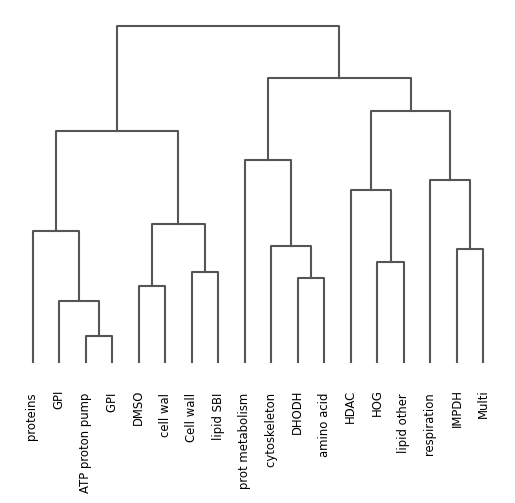

<Axes: >

In [23]:
sc.tl.dendrogram(adata, groupby="Metadata_Mode_of_Action")
sc.pl.dendrogram(adata, groupby="Metadata_Mode_of_Action")

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


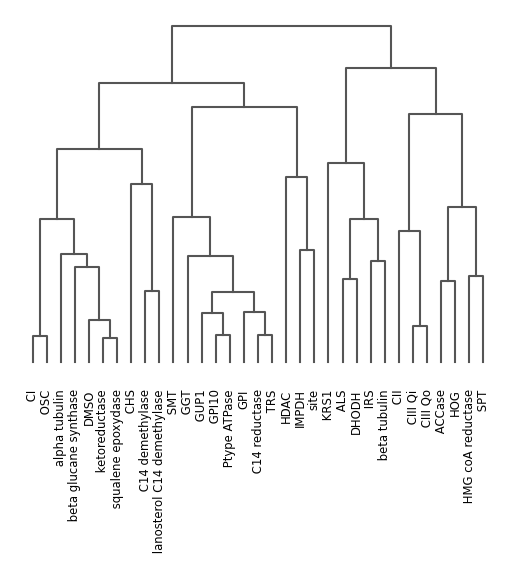

<Axes: >

In [24]:
sc.tl.dendrogram(adata, groupby="Metadata_target")
sc.pl.dendrogram(adata, groupby="Metadata_target")

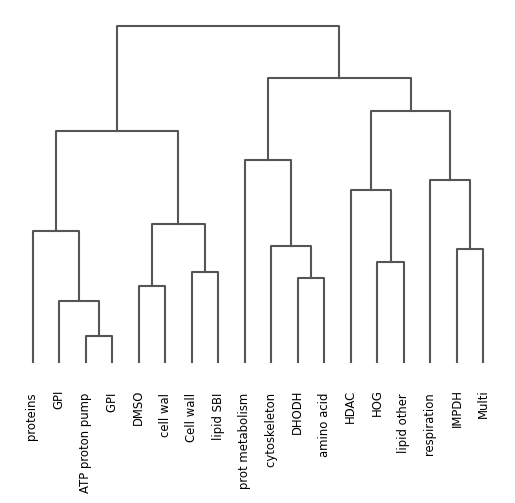

<Axes: >

In [25]:
sc.pl.dendrogram(adata, groupby="Metadata_Mode_of_Action")

In [26]:
adata = adata_backup.copy()

In [27]:
df_counts = adata.to_df()
gene_columns = df_counts.columns
df_meta = adata.obs

df_meta.rename(columns = {
    "leiden": "Metadata_leiden",
    "Metadata_row": "Metadata_plate_row",
    "Metadata_column": "Metadata_plate_column",
    "Metadata_treatments": "Metadata_treatment",
    "Metadata_wells": "Metadata_well",
}, inplace = True)
df_meta = df_meta.loc[:, df_meta.columns.str.startswith("Metadata_")]
df_meta.columns = [col.capitalize() for col in df_meta.columns]
combined_df = pd.concat([df_counts, df_meta], axis=1)

In [28]:
import pandas as pd
import numpy as np

# Assuming combined_df is your DataFrame with gene expression and metadata
# Replace 'gene_0', 'gene_1', ..., 'gene_n' with actual gene column names if needed
# Create a new column for outlier labeling
combined_df['Metadata_replicate_outlier'] = 0  # Default label

# Group by treatment and concentration
groups = combined_df.groupby(['Metadata_treatment', 'Metadata_concentration'])

# Loop through each group
for (treatment, concentration), group in groups:
    # Calculate the mean expression for each gene in the group


    mean_expression = group[gene_columns].mean()
    # Calculate the distance of each replicate from the mean
    distances = np.linalg.norm(group[gene_columns] - mean_expression, axis=1)
    # Identify the indices of the two replicates with the maximum distances
    outlier_indices = group.index[np.argsort(distances)[-2:]]
    # Label the outliers
    combined_df.loc[outlier_indices, 'Metadata_replicate_outlier'] = 1
    # Now combined_df has a new column indicating the outlier for each group

/tmp/ipykernel_97820/2825001412.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = combined_df.groupby(['Metadata_treatment', 'Metadata_concentration'])


In [29]:
combined_df.sort_values(['Metadata_treatment', 'Metadata_concentration'], ascending=False, inplace = True)

In [30]:
combined_df["Metadata_plate"].unique()

['L111224TS01_01', 'L111224TS02_01', 'L111224TS03_01', 'L111224TS04_01', 'L111224TS05_01', ..., 'L111224TS12_01', 'L111224TS13_01', 'L111224TS14_01', 'L111224TS15_01', 'L111224TS16_01']
Length: 15
Categories (15, object): ['L111224TS01_01', 'L111224TS02_01', 'L111224TS03_01', 'L111224TS04_01', ..., 'L111224TS13_01', 'L111224TS14_01', 'L111224TS15_01', 'L111224TS16_01']

In [31]:
combined_df.to_csv("lyon_scanpy_normalised_data_and_meta.csv")

In [32]:
meta_columns = df.columns[df.columns.str.startswith("Metadata_")]


In [33]:
meta_columns

Index(['Metadata_Wells', 'Metadata_plate', 'Metadata_row', 'Metadata_col',
       'Metadata_Mode_of_Action', 'Metadata_fraction_nb',
       'Metadata_treatments', 'Metadata_concentration', 'Metadata_MoA',
       'Metadata_target', 'Metadata_log_concentration'],
      dtype='object')

In [34]:
target2moa = dict(zip(adata.obs["Metadata_target"],adata.obs["Metadata_Mode_of_Action"]))

In [35]:
adata = adata_backup.copy()
#adata = groupby_adata.copy()

In [36]:
adata.obs.rename(columns = {"leiden": "Metadata_leiden"}, inplace = True)

In [37]:
adata.obs.columns

Index(['Metadata_Wells', 'Metadata_plate', 'Metadata_row', 'Metadata_col',
       'Metadata_Mode_of_Action', 'Metadata_fraction_nb',
       'Metadata_treatments', 'Metadata_concentration', 'Metadata_MoA',
       'Metadata_target', 'Metadata_log_concentration', 'n_counts',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'Metadata_leiden'],
      dtype='object')

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Array of categories
categories = adata.obs["Metadata_target"].unique()

# Extract prefixes (text before colon or the full string if no colon exists)
prefixes = target2moa.values()

# Get unique prefixes
unique_prefixes = list(set(prefixes))

# Generate a base color for each unique prefix
base_colors = sns.color_palette("tab10", n_colors=len(unique_prefixes))  # Use a distinct palette
prefix_color_map = {prefix: base_colors[i] for i, prefix in enumerate(unique_prefixes)}

# Assign colors to each category with slight variations
category_colors = []
for category in categories:
    prefix = target2moa[category]
    base_color = prefix_color_map[prefix]
    
    # Create a slight variation of the base color
    variation_index = list(categories).index(category) % 10  # Ensure index is within range
    varied_color = sns.light_palette(base_color, n_colors=10)[variation_index]
    category_colors.append(varied_color)

# Create a dictionary mapping categories to colors
category_color_map = {cat: color for cat, color in zip(categories, category_colors)}

# Update the category_color_map with prefix colors as well
category_color_map.update(prefix_color_map)

# Example of how to use the category_color_map to color a plot
# plt.scatter(x, y, c=[category_color_map[cat] for cat in adata.obs["Metadata_target"]])
# plt.show()

/tmp/ipykernel_97820/2726650320.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for mode, group in adata.obs.groupby("Metadata_Mode_of_Action"):


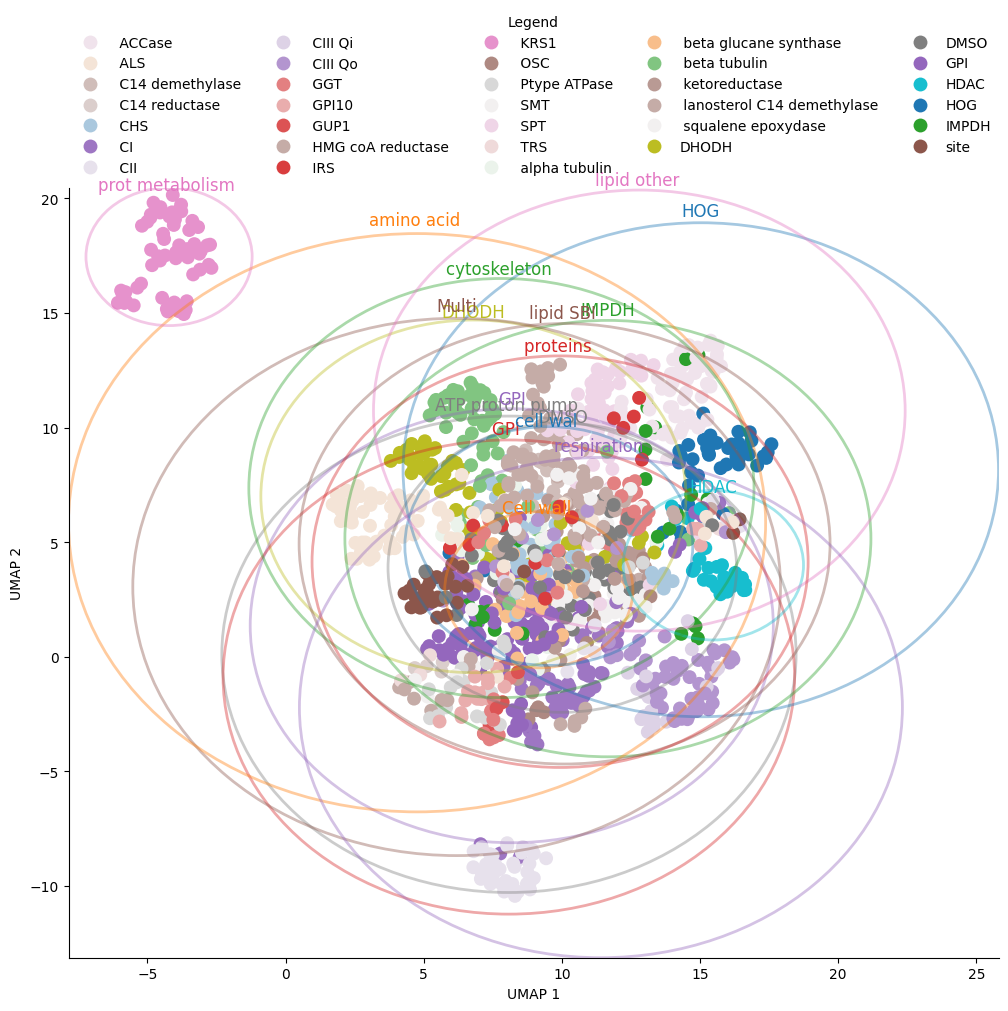

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

adata.obs["UMAP 1"] = adata.obsm["X_umap"][:,0]
adata.obs["UMAP 2"] = adata.obsm["X_umap"][:,1]

# Define unique markers for "Metadata_FRAC_sub_group"
markers = [ f"${i}$" for i in range(adata.obs["Metadata_leiden"].nunique()) ]
marker_map = dict(zip(adata.obs["Metadata_leiden"].unique(), markers))

# Plot using matplotlib

fig = plt.figure(figsize = (12,10))

ax = plt.gca()
sns.scatterplot(
    data = adata.obs,
    x = "UMAP 1",
    y = "UMAP 2",
    #size = "Log Concentration",
    s = 100,
    lw = 0,
    hue = "Metadata_target",
    #palette = "Set3",
    palette = category_color_map,
    #style = "Metadata_leiden",
    #markers = marker_map,
    alpha = 1,
    ax = ax
)

min_x = adata.obs["UMAP 1"].min()
min_y = adata.obs["UMAP 2"].min()
max_x = adata.obs["UMAP 1"].max()
max_y = adata.obs["UMAP 2"].max()

# Calculate cluster centers and radii for "Metadata_Mode_of_Action"
# Calculate cluster centers and radii for "Metadata_Mode_of_Action"
for mode, group in adata.obs.groupby("Metadata_Mode_of_Action"):
    # Cluster center
    center_x, center_y = group["UMAP 1"].mean(), group["UMAP 2"].mean()
    # Calculate radius as the maximum distance from the center
    radius = np.sqrt(((group["UMAP 1"] - center_x) ** 2 + (group["UMAP 2"] - center_y) ** 2).max())
        # Update min/max values to include circle boundaries
    min_x = min(min_x, center_x - radius * 1.1)
    max_x = max(max_x, center_x + radius * 1.1)
    min_y = min(min_y, center_y - radius * 1.1)
    max_y = max(max_y, center_y + radius * 1.1)
    # Add circle
    circle = Circle(
        (center_x, center_y), 
        radius=radius * 1.1, 
        color=category_color_map[mode], 
        fill=False, 
        #fill=True,
        linewidth=2, 
        #linewidth=0, 
        alpha=0.4, 
        linestyle="-"
    )
    ax.add_patch(circle)
    
    # Annotate with Mode of Action above the circle
    ax.text(
        center_x, 
        center_y + radius * 1.15,  # Offset to position above the circle
        mode, 
        fontsize=12, 
        ha="center", 
        va="center", 
        color=category_color_map[mode], 
        #bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
    )
# plt.title("UMAP Plot with Automatic Circles Around Mode of Action Clusters")
# plt.show()
#ax.set_axis_off()

# Set axis limits
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5, title="Legend", frameon=False,
)
ax.spines[['right', 'top']].set_visible(False)

# # Create custom legend handles for "Metadata_target" with circular markers
# legend_handles = [
#     Line2D(
#         [0], [0],
#         marker='o',  # Circular marker
#         color=category_color_map[group],
#         label=group,
#         markerfacecolor=category_color_map[group],
#         markersize=10,
#         linestyle='None'
#     )
#     for group in sorted(adata.obs["Metadata_target"].unique())
# ]
# legend_handles.append(
#     Line2D(
#         [0], [0],
#         marker='$1$',  # Circular marker
#         color="silver",
#         label="Metadata_leiden",
#         #markerfacecolor=category_color_map[group],
#         markersize=10,
#         linestyle='None'
#     )
# )

# Add the legend with custom handles
# Add the legend with custom handles
# ax.legend(
#     handles=legend_handles,
#     title="Metadata_target",
#     bbox_to_anchor=(0.5, -0.1),  # Position below the plot
#     loc="upper center",          # Center the legend below the plot
#     ncol=2,                      # Arrange legend items in a single row
#     frameon=False                # Remove legend frame
# )
plt.savefig("cluster_plot.png", bbox_inches='tight')
plt.savefig("cluster_plot.svg")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.close()


In [40]:
# df = adata.to_df()
df = combined_df.copy()

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

def plot_mahalanobis_stripplot(df, treatment_col, reference="DMSO", mode_of_action_col="Metadata_Mode_of_Action", category_color_map=category_color_map):
    """
    Plot a strip plot of Mahalanobis distances of treatments to a reference (DMSO),
    ordered by their mode of action and split by technology, with individual points sized by concentration.

    Parameters:
    - df: Input DataFrame
    - treatment_col: Column containing treatment categories (e.g., Metadata_treatments)
    - reference: Name of the reference treatment (default: "DMSO")
    - mode_of_action_col: Column containing mode of action categories (default: "Metadata_Mode_of_action")
    - technology_col: Column indicating the technology type (e.g., Alithea or Bulk)
    - timepoint_col: Column indicating timepoints to define stripplot symbols
    - concentration_col: Column indicating concentration to define point size

    Returns:
    - None
    """
    

    feature_columns = [col for col in df.columns if not col.startswith("Metadata_")]
    meta_columns = [ col for col in df.columns if col.startswith("Metadata_")]
    df[feature_columns] = df[feature_columns].fillna(0)
    
    variances = df[feature_columns].var().sort_values(ascending=False)
    top_columns = variances[variances > 1e-5].head(2000).index.tolist()  # Ensure variance is above a threshold
    df = df[top_columns+ meta_columns]
    df[top_columns] = StandardScaler().fit_transform(df[top_columns])
    feature_columns = [col for col in df.columns if not col.startswith("Metadata_")]

    df.rename(columns = {
        f"{treatment_col}": "Treatment",
        f"{mode_of_action_col}": "Mode of Action",
        "Metadata_target": "Target",
    }, inplace = True)

    reference_data = df.loc[df["Treatment"] == "DMSO" , feature_columns].copy()
    # Compute the inverse covariance matrix for Mahalanobis distance
    cov_matrix = np.cov(reference_data.T) + np.eye(reference_data.shape[1]) * 1e-5  # Regularization
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    reference_mean = reference_data.mean().to_numpy()

    # Compute Mahalanobis distance for each treatment
    distances = []
    for treatment, group in df.groupby(["Treatment"]):
        if treatment == reference:
            continue
        for idx, row in group.iterrows():
            distances.append({
                "Treatment": treatment,
                "Metadata_Mode_of_Action": row[mode_of_action_col],
                "Metadata_target": row["Target"],
                "Mahanolobis distance": mahalanobis(row[feature_columns].to_numpy(), reference_mean, inv_cov_matrix)
            })

    # Create a new DataFrame for visualization
    distance_df = pd.DataFrame(distances)
    
    # Sort by mode of action, treatment, and technology
    distance_df = distance_df.sort_values(by=["Metadata_Mode_of_Action", "Mahanolobis distance"])

    return distance_df

In [42]:
meta_columns = df.columns[df.columns.str.startswith("Metadata_")]
meta_columns


Index(['Metadata_wells', 'Metadata_plate', 'Metadata_plate_row',
       'Metadata_col', 'Metadata_mode_of_action', 'Metadata_fraction_nb',
       'Metadata_treatment', 'Metadata_concentration', 'Metadata_moa',
       'Metadata_target', 'Metadata_log_concentration', 'Metadata_leiden',
       'Metadata_replicate_outlier'],
      dtype='object')

In [43]:
distance_df = plot_mahalanobis_stripplot(df.copy(), treatment_col = "Metadata_treatment", mode_of_action_col="Metadata_Mode_of_Action", category_color_map = category_color_map)

/tmp/ipykernel_97820/1816764587.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for treatment, group in df.groupby(["Treatment"]):


KeyError: 'Metadata_Mode_of_Action'

In [ ]:
distance_df["Treatment"] = [ x[0] for x in distance_df["Treatment"] ]

In [ ]:
distance_df.head()

In [ ]:
treatment2frac = dict(zip(distance_df["Treatment"], distance_df["Metadata_target"]))
treatment2colour = dict([ (x, category_color_map[treatment2frac[x]]) for x in distance_df["Treatment"].unique()])

In [ ]:

import numpy as np
from scipy.spatial.distance import mahalanobis
import itertools
import matplotlib.pyplot as plt
from scipy.stats import shapiro


def mahanolobis_threshold(references_df, regularization=1e-5):
    # Assuming you have three DMSO references in a list or array
    # Convert DataFrame to a numpy array for easier manipulation
    references_df = references_df.fillna(0).copy()
    references_array = references_df.to_numpy()

    # Generate bootstrap samples with noise
    # bootstrap_array = bootstrap_samples_with_noise(references_array, n_bootstrap_samples, noise_level)
    bootstrap_array = references_array
    
    # Initialize a list to store Mahalanobis distances
    mahalanobis_distances = []

    # Perform LOOCV on bootstrap samples
    for index in range(bootstrap_array.shape[0]):
        # Get the left-out index
        ref_index = bootstrap_array[index]

        # Get the remaining references
        remaining_indices = list(set(range(bootstrap_array.shape[0])) - {index})
        ref_remain = bootstrap_array[remaining_indices]
        

        # Calculate mean and covariance for the two references
        mean_pair = np.mean(ref_remain, axis=0)
        cov_pair = np.cov(ref_remain.T)

        # Add regularization to the covariance matrix
        cov_pair += np.eye(cov_pair.shape[0]) * regularization
        inv_cov_pair = np.linalg.inv(cov_pair)

        distance = mahalanobis(ref_index, mean_pair, inv_cov_pair)
        mahalanobis_distances.append(distance)

    return mahalanobis_distances


In [ ]:
meta_columns = df.columns[df.columns.str.startswith("Metadata_")]
feature_columns = df.columns[~df.columns.str.startswith("Metadata_")]


In [ ]:
reference_data = df.loc[df["Metadata_treatment"] == "DMSO" , feature_columns].copy()
# Compute the inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(reference_data.T) + np.eye(reference_data.shape[1]) * 1e-5  # Regularization
inv_cov_matrix = np.linalg.inv(cov_matrix)

In [ ]:
distances_threshold = mahanolobis_threshold(reference_data, regularization=1e-5)

In [ ]:
bcs2target = dict(zip(df["Metadata_treatment"], df["Metadata_target"]))

In [ ]:
distances_threshold = pd.Series(distances_threshold)
threshold = distances_threshold.mean() + 3 * distances_threshold.std()

In [ ]:
distance_df["Metadata_target"] = distance_df["Treatment"].map(bcs2target)

In [ ]:
distance_df.head()

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

scaler = MinMaxScaler()

func = lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten()

plt.hist(func(distances_treatment), bins=50)

In [ ]:
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

significant_difference = {}

# Perform t-tests for each treatment
for treatment in distance_df["Metadata_target"].unique():
    if treatment == "DMSO":
        continue
    distances_treatment = distance_df.loc[distance_df["Metadata_target"] == treatment, "Mahalanobis Distance to DMSO"]

    # Check if normality and equal variance assumptions hold
    normality_test = stats.shapiro(distances_treatment)
    # You can also check Levene's test for equal variance if needed

    # Perform the t-test or Mann-Whitney U test based on assumptions
    t_stat, p_value = stats.ttest_ind(func(distances_treatment), func(distances_threshold), alternative='greater', equal_var=False)

    # print(treatment, p_value, normality_test)
    significant_difference[treatment] = p_value

# Correct for multiple comparisons
p_values = list(significant_difference.values())
corrected_pvals = multipletests(p_values, method='bonferroni')[1]  # Benjamini-Hochberg

# Print corrected p-values
for treatment, corrected_p in zip(significant_difference.keys(), corrected_pvals):
    print(treatment, corrected_p)

In [ ]:
# Rename columns for better readability
distance_df.rename(columns={
    "Metadata_Mode_of_Action": "Mode of Action\n",
    "Mahanolobis distance": "Mahalanobis Distance to DMSO",
}, inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Assuming category_color_map is defined somewhere in your code
# Example:
# category_color_map = {
#     'Treatment 1': 'red',
#     'Treatment 2': 'blue',
#     'Treatment 3': 'green',
#     # Add more treatments and their corresponding colors
# }

distance_df.sort_values("Metadata_target", ascending=True, inplace=True)

# Plot the strip plot
fig = plt.figure(figsize=(15, 20))
ax = plt.gca()

# Create the strip plot
sns.stripplot(
    data=distance_df,
    x="Mahalanobis Distance to DMSO",
    y="Treatment",
    hue="Metadata_target",
    dodge=True,
    alpha=0.7,
    s=10,
    jitter=False,
    ax=ax,
    #palette = "tab10"
    palette=category_color_map,
)
ax.axvline(threshold, color="silver", linestyle="--", label="Threshold")
ax.spines[['right', 'top']].set_visible(False)

# Customize the plot
fig.suptitle("Mahalanobis Distance to Reference (DMSO)", fontsize=16)
plt.xlabel("Mahalanobis Distance", fontsize=14)
plt.ylabel("Treatments (Ordered by Mode of Action)", fontsize=14)

# Set smaller font size for y tick labels
ax.tick_params(axis='y', labelsize=6)  # Adjust the labelsize as needed

# Move legend
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()
plt.close()

In [ ]:

import numpy as np
from scipy.spatial.distance import mahalanobis
import itertools
import matplotlib.pyplot as plt
from scipy.stats import shapiro


def bootstrap_samples_with_noise(references_array, n_samples, noise_level=1.0):
    """Generate bootstrap samples by drawing randomly from each column of the references and adding noise."""
    n_references, n_features = references_array.shape
    bootstrap_samples = np.zeros((n_samples, n_features))
    
    # Calculate the mean of the original references
    mean_reference = np.mean(references_array, axis=0)
    
    # Calculate the noise as the standard deviation of the differences from the mean
    noise = np.std(references_array - mean_reference, axis=0)
    
    for i in range(n_samples):
        for j in range(n_features):
            bootstrap_samples[i, j] = np.random.choice(references_array[:, j]) + np.random.normal(0, noise_level * noise[j])
    
    return bootstrap_samples

def mahanolobis_threshold_with_bootstrap_and_noise(references_df, n_bootstrap_samples=100, regularization=1e-5, noise_level=0):
    # Assuming you have three DMSO references in a list or array
    # Convert DataFrame to a numpy array for easier manipulation
    references_df = references_df.fillna(0).copy()
    references_array = references_df.to_numpy()

    # Generate bootstrap samples with noise
    # bootstrap_array = bootstrap_samples_with_noise(references_array, n_bootstrap_samples, noise_level)
    bootstrap_array = references_array
    
    # Initialize a list to store Mahalanobis distances
    mahalanobis_distances = []

    # Perform LOOCV on bootstrap samples
    for index_c in range(bootstrap_array.shape[0]):
        # Get the left-out reference
        ref_c = bootstrap_array[index_c]

        # Get the remaining references
        remaining_indices = list(set(range(bootstrap_array.shape[0])) - {index_c})
        ref_a = bootstrap_array[remaining_indices[0]]
        ref_b = bootstrap_array[remaining_indices[1]]

        # Calculate mean and covariance for the two references
        mean_pair = np.mean([ref_a, ref_b], axis=0)
        cov_pair = np.cov(np.vstack([ref_a, ref_b]).T)

        # Add regularization to the covariance matrix
        cov_pair += np.eye(cov_pair.shape[0]) * regularization
        inv_cov_pair = np.linalg.inv(cov_pair)

        distance = mahalanobis(ref_c, mean_pair, inv_cov_pair)
        mahalanobis_distances.append(distance)

    return mahalanobis_distances

# Example usage (assuming reference_data_multiplexed is your DataFrame)
# distances = mahanolobis_threshold_with_bootstrap_and_noise(reference_data_multiplexed)

# Calculate mean, standard deviation, and threshold
# mean_distance = np.mean(distances)
# std_distance = np.std(distances)
# sem_distance = std_distance / np.sqrt(len(distances))
# threshold = mean_distance + 3 * sem_distance

# Plot histogram of Mahalanobis distances
def plot_histogram(distances):
    plt.hist(distances, bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Frequency')
    plt.show()

def mahanolobis_with_upsampling(subsample_df, inv_cov_matrix, referece_mean, n_bootstrap_samples=100, regularization=1e-5, noise_level=0):
    # Assuming you have three DMSO references in a list or array
    # Convert DataFrame to a numpy array for easier manipulation
    subsample_df = subsample_df.copy()
    subsample_array = subsample_df.to_numpy()
    # Generate bootstrap samples with noise
    bootstrap_array = bootstrap_samples_with_noise(subsample_array, n_bootstrap_samples, noise_level)
    # Initialize a list to store Mahalanobis distances
    mahalanobis_distances = []

    # Perform LOOCV on bootstrap samples
    for i in range(bootstrap_array.shape[0]):
        # Get the left-out reference
        row = bootstrap_array[i]

        distance = mahalanobis(row, referece_mean, inv_cov_matrix)
        mahalanobis_distances.append(distance)
    return(mahalanobis_distances)
    
def bootstrap_difference(subsample_df, reference_df, n_bootstrap_samples=100, regularization=1e-5, noise_level=0, top_n_genes=100):

    # Calculate the mean expression of the filtered DataFrames
    expression_sample = subsample_df.mean().to_numpy()
    expression_reference = reference_df.mean().to_numpy()

    # Perform t-test comparing the sample to the reference mean
    u_stat, p_value = stats.mannwhitneyu(expression_sample, expression_reference)

    return p_value
    # Initialize a list
